In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle
#from models import load_dataset
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sys
sys.path.append("../data")
from process_speech_data import load_speech_data

In [93]:
#Chargement du dataset
data = load_speech_data("../data/speechs_data.json", "../data/annotated_speakers.csv")

extreme_droite_data = load_speech_data("../data/speech_data_ExRight.json", "../data/annotated_speakers.csv")

# Combine the datasets
data = pd.concat([data, extreme_droite_data], ignore_index=True)

data

/home/matthias/epita/ing2/nlp/nlp1-project/models/../data/process_speech_data.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speaker'] = df['speaker'].astype(int)


,speaker,text
0,2,DIMITRI PAVLENKO\nBonjour Jean-Baptiste DJEBBA...
1,4,"Mes chers amis,\nMerci pour votre accueil. C’e..."
2,4,"Mes chers compatriotes,\nToute ma vie, je me s..."
3,4,"Mes très, très, chers amis ! Il est d’usage de..."
4,2,MARIE BERNARDEAU\nBonjour Barbara POMPILI.\nBA...
...,...,...
70965,4,"Bonjour à tous, merci pour votre présence.\n\n..."
70966,4,"Bonjour à tous, bonjour mes amis !\n\nQuelle p..."
70967,4,"Bonjour à tous, bonjour mes amis !\n\nQuelle p..."
70968,4,"Bonjour à tous ! Merci beaucoup, merci… Décidé..."


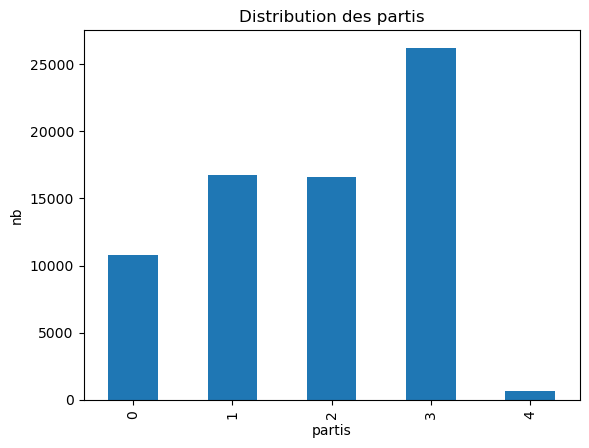

In [94]:
# afficher la repartition des differentes classes "speaker" du dataframe data avec un plot. ranger les calsses de 0 a 4 
data['speaker'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('partis')
plt.ylabel('nb')
plt.title('Distribution des partis')
plt.show()

# Afficher le nombre d'exemples par speaker

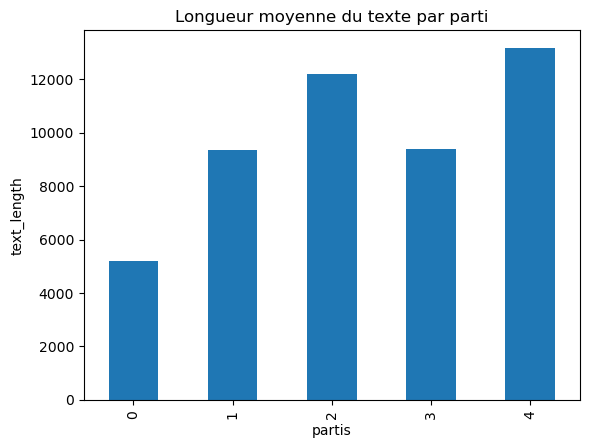

In [95]:
# Affichier le nombre de caractere de text moyen par classe
data['text_length'] = data['text'].apply(len)
data.groupby('speaker')['text_length'].mean().sort_index().plot(kind='bar')
plt.xlabel('partis')
plt.ylabel('text_length')
plt.title('Longueur moyenne du texte par parti')
plt.show()

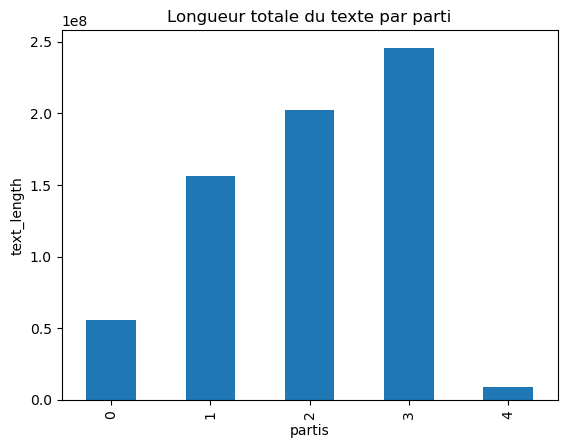

speaker
0     55765019
1    156588967
2    202414694
3    245754577
4      8854777
Name: text_length, dtype: int64


In [96]:
# Afficher le nombre de caractere de text par classe 
data['text_length'] = data['text'].apply(len)
data.groupby('speaker')['text_length'].sum().sort_index().plot(kind='bar')
plt.xlabel('partis')
plt.ylabel('text_length')
plt.title('Longueur totale du texte par parti')
plt.show()


print(data.groupby('speaker')['text_length'].sum().sort_index())


In [97]:
#randomly cut dataset to smaller for testing
# to speed up the process, we can randomly cut the dataset to a smaller size
# Uncomment the following line to use the full dataset
# data = data.sample(frac=1, random_state=42)
data = data.sample(frac=0.01, random_state=42)

In [98]:
# print data type of speaker column 
print(data['text'].dtype)
# print nymber of nonetype in text column
print(data['text'].isnull().sum())
# print lines with nonetype in text column
print(data[data['text'].isnull()])

print(data.shape)

object
0
Empty DataFrame
Columns: [speaker, text, text_length]
Index: []
(710, 3)


In [99]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords


# Stop words par défaut (ex: français)
stop_words = set(stopwords.words('french'))
print(stop_words)

# Ajouter des mots personnalisés (ex: "voici", "etc", "chose")
custom_stop_words = {"jour", "\'","nest","a","si", "à","ça", "ça" ,"q", "r", "dune", "dun" "a", "cest", "cette", "aussi", "tout", "donc", "quil", "comme", "mais", "pourquoi", "parceque", "voici", "etc", "chose", "aussi", "tous", "toutes", "tout", "toute", "cela", "ceci", "ceux", "celles"}
stop_words.update(custom_stop_words)

print(stop_words)

{'n', 'étions', 'étantes', 'sera', 'vous', 'sont', 'eus', 'auriez', 'est', 'été', 'eues', 'avaient', 'eue', 'lui', 'et', 'étante', 'd', 'aies', 'ont', 'un', 'seraient', 'on', 'au', 'eurent', 'furent', 'serait', 'mon', 'me', 'ces', 'étée', 'ayant', 'ne', 'par', 'aurai', 'fûmes', 'aient', 'avais', 'ils', 'ou', 'son', 'seriez', 'ta', 'avec', 'es', 'auraient', 'serai', 'se', 'avez', 'étiez', 'aux', 'eût', 'des', 'avions', 'eûmes', 'eussent', 'sur', 'de', 'ayons', 'fût', 'du', 'mes', 'pour', 'fûtes', 'moi', 'j', 'serons', 'aie', 'nos', 'toi', 'étants', 'étant', 'seras', 'notre', 'soient', 'mais', 'eusse', 'sa', 'fus', 'serions', 'serez', 'pas', 'votre', 'qu', 'ayez', 'nous', 'ait', 'ayants', 'auras', 'aura', 'ce', 'étaient', 'soyez', 'soit', 'l', 'en', 'elle', 'avons', 'm', 'une', 'ayantes', 'la', 'tes', 'leur', 'suis', 'avait', 'sommes', 'à', 'fussions', 'sois', 'eusses', 's', 'ai', 'vos', 'ayante', 'ma', 'il', 'était', 'aurions', 't', 'soyons', 'que', 'eu', 'auront', 'c', 'dans', 'aurais'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
import string
import unicodedata
import re
nltk.download('punkt_tab')

from nltk.stem.snowball import FrenchStemmer

a_supprimer = "`',!?’.:%;()[]{}<>\"\\/\n\r\t"
stemmer = FrenchStemmer()

def preprocess_text(text):

    # Supprimer les caractères spéciaux et les chiffres
    text = unicodedata.normalize("NFC", text)
    # Convertir en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = re.sub(rf"[{re.escape(a_supprimer)}]", " ", text)
    # # Supprimer les - 
    # text = text.replace("-", "")
    
    # Supprimer les chiffres
    text = ''.join([i for i in text if not i.isdigit()])

    # Combler les suites d'espaces
    text = re.sub(r"\s+", " ", text).strip()
    return text
    
def tokenise(text):
    # Tokenization et suppression des stopwords
    tokens = nltk.word_tokenize(text, language='french')
    tokens = [word for word in tokens if word not in stop_words]

    # Standardisation des mots 
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

data['text'] = data['text'].apply(preprocess_text)

data['text'] = data['text'].apply(tokenise)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/matthias/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


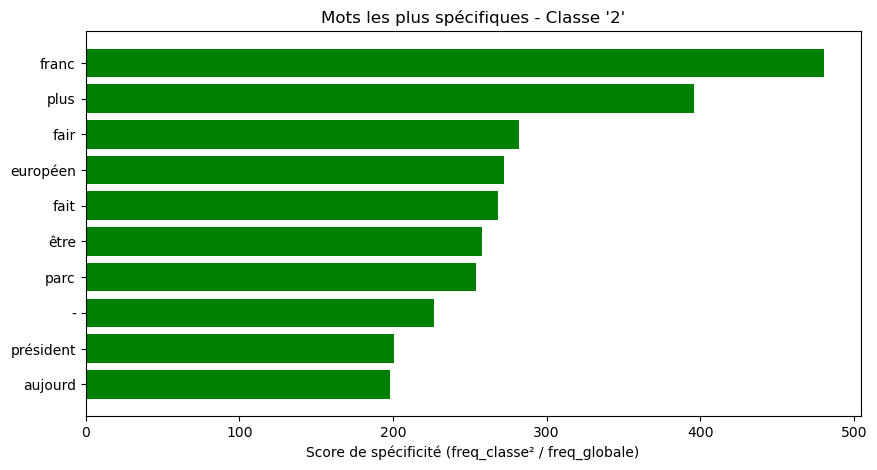

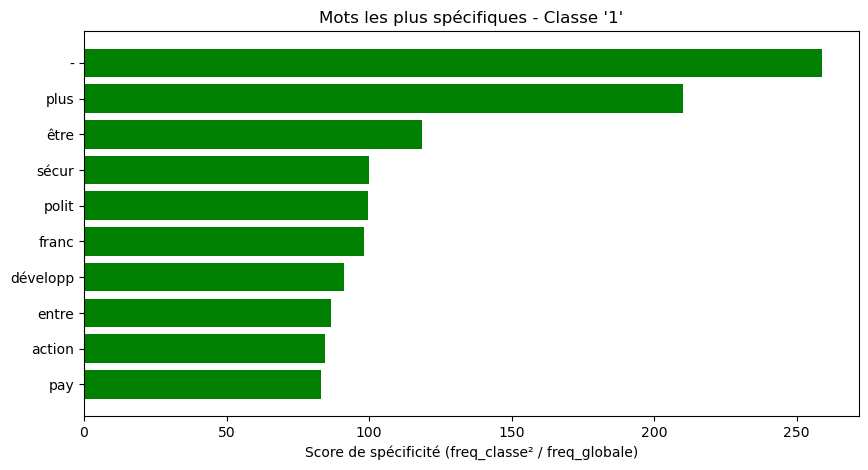

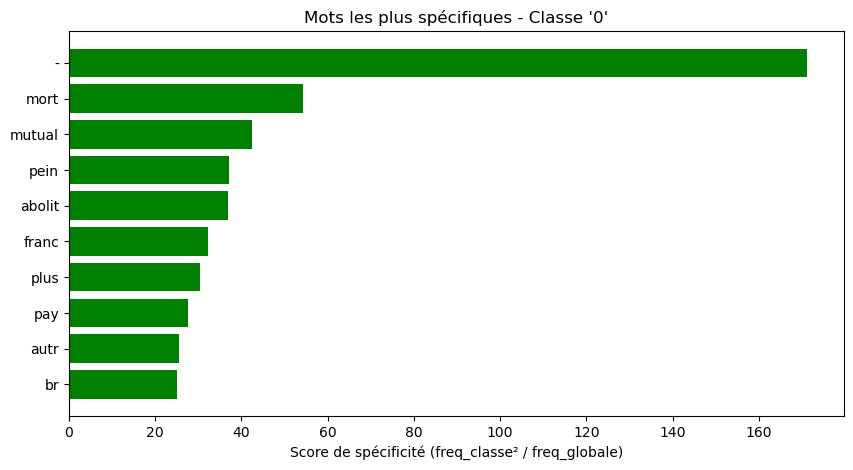

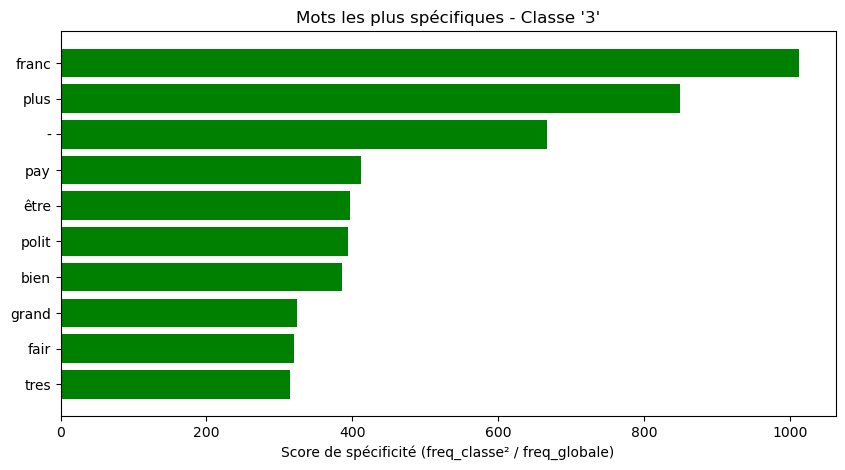

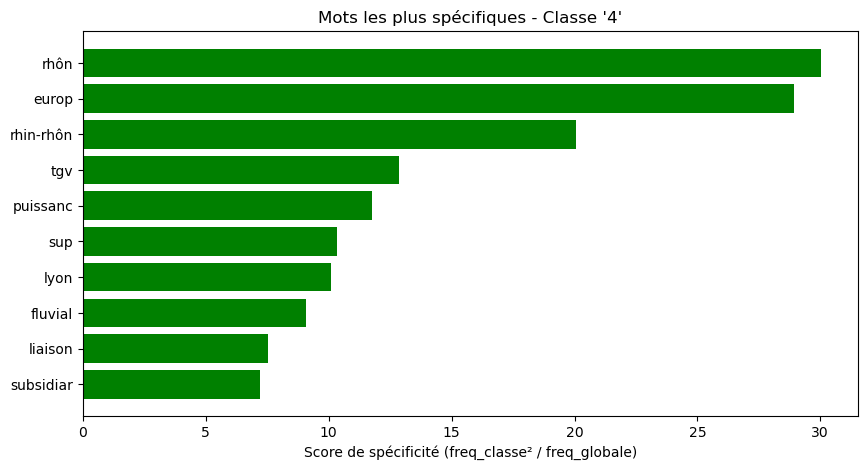

In [101]:
from collections import Counter, defaultdict

# Afficher les mots les plus frequent de chaque classe pondérés par leur nombre total d'apparition dans le dataset 

# 1. Compter les occurrences globales et par classe
global_word_count = Counter()
class_word_counts = defaultdict(Counter)

for idx, row in data.iterrows():
    tokens = row['text']  # Liste de tokens prétraités
    label = row['speaker']
    global_word_count.update(tokens)  # Mettre à jour le compteur global
    class_word_counts[label].update(tokens)  # Mettre à jour le compteur par classe

# 2. Calculer le score de spécificité (freq_classe² / freq_globale)
class_specific_scores = defaultdict(dict)

for label, word_counts in class_word_counts.items():
    for word, count in word_counts.items():
        total_count = global_word_count[word]
        score = (count ** 2) / total_count if total_count > 0 else 0
        class_specific_scores[label][word] = score

# 3. Afficher les top mots par classe
for label, scores in class_specific_scores.items():
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    words = [word for word, _ in sorted_words]
    values = [score for _, score in sorted_words]
    
    plt.figure(figsize=(10, 5))
    plt.barh(words, values, color='green')
    plt.title(f"Mots les plus spécifiques - Classe '{label}'")
    plt.xlabel("Score de spécificité (freq_classe² / freq_globale)")
    plt.gca().invert_yaxis()  # Mot le plus important en haut
    plt.show()

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Afficher les mots les plus significatifs de chaques classes selon TFIDF
# TODO Afficher les bigrams les plus significatifs de chaques classes selon TFIDF
# => pareil avec tri gram ect ????

# Chaque ligne devient une string (les tokens sont déjà nettoyés)
data['joined_text'] = data['text'].apply(lambda tokens: ' '.join(tokens))

# On vectorise tous les textes
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))  # tu peux augmenter/diminuer
X = vectorizer.fit_transform(data['joined_text'])

# Récupération des mots du vocabulaire
feature_names = vectorizer.get_feature_names_out()

# DataFrame TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
tfidf_df['speaker'] = data['speaker'].values

# Moyenne TF-IDF des mots pour chaque parti
grouped = tfidf_df.groupby('speaker').mean()

def plot_top_tfidf_words(party_id, n=10):
    scores = grouped.loc[party_id]
    top_words = scores.sort_values(ascending=False).head(n)
    
    plt.figure(figsize=(10, 5))
    plt.bar(top_words.index, top_words.values, color='mediumseagreen')
    plt.title(f"Top {n} mots TF-IDF pour le parti {party_id}")
    plt.xticks(rotation=45)
    plt.ylabel("Score TF-IDF moyen")
    plt.tight_layout()
    plt.show()

def plot_top_tfidf_bigram_words(party_id, n=10):
    scores = grouped.loc[party_id]
    top_words = scores.sort_values(ascending=False).head(n)
    
    plt.figure(figsize=(10, 5))
    plt.bar(top_words.index, top_words.values, color='mediumseagreen')
    plt.title(f"Top {n} bigrammes TF-IDF pour le parti {party_id}")
    plt.xticks(rotation=45)
    plt.ylabel("Score TF-IDF moyen")
    plt.tight_layout()
    plt.show()
    

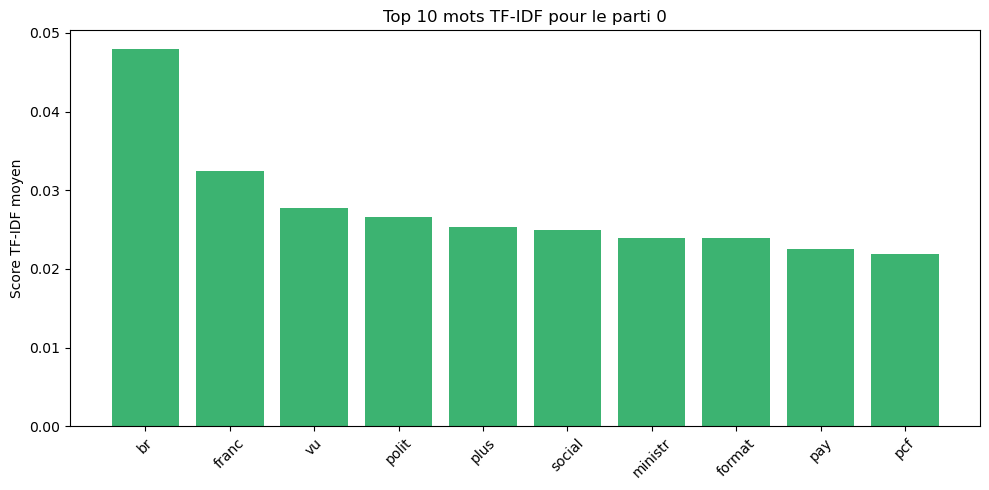

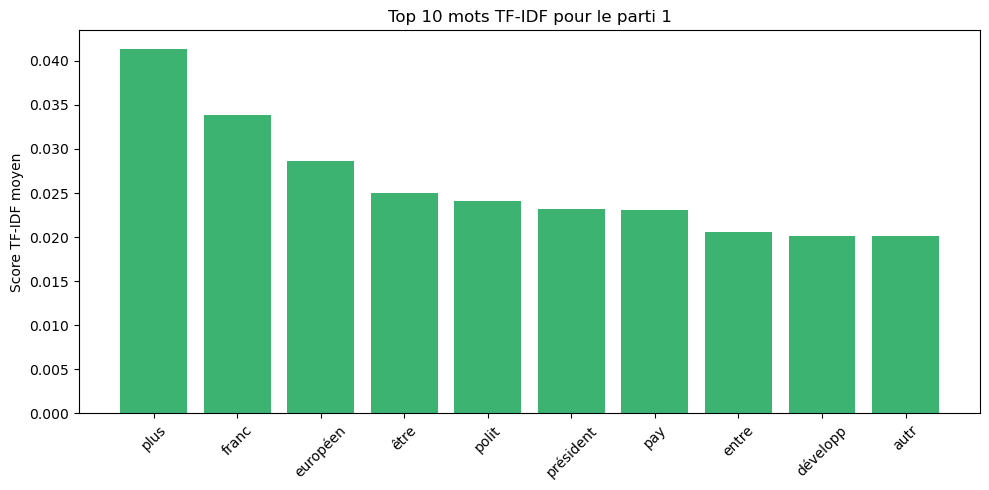

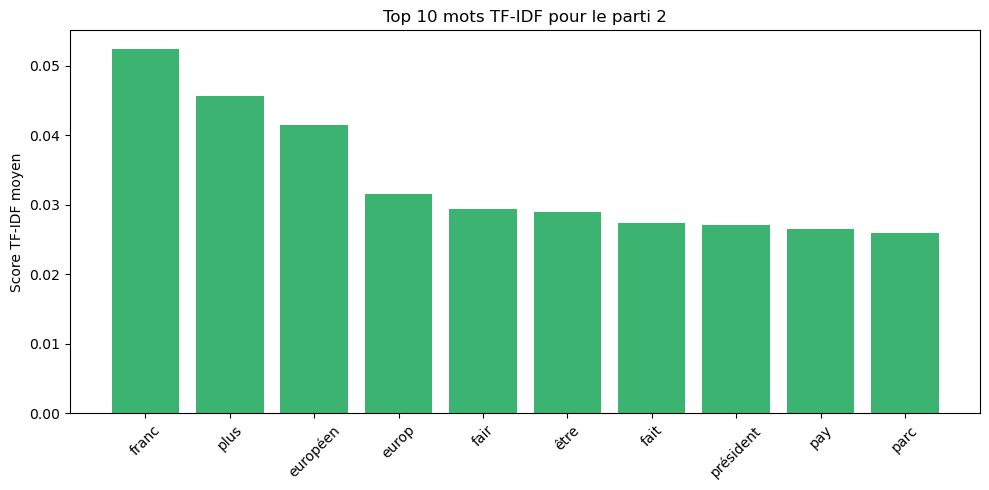

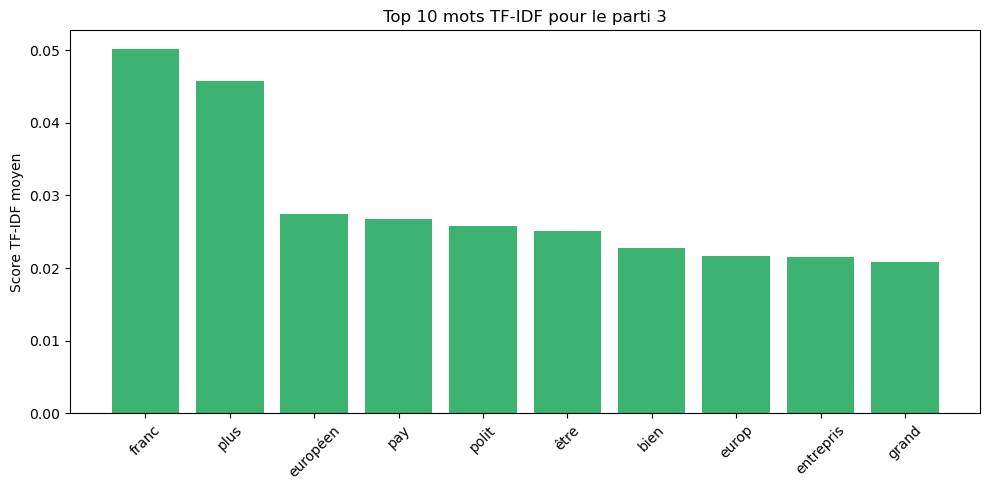

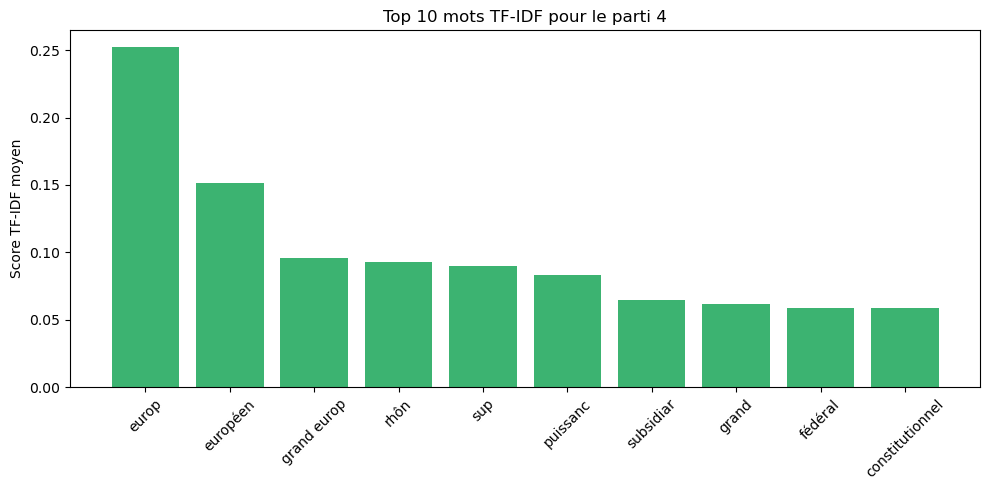

In [103]:
plot_top_tfidf_words(0)
plot_top_tfidf_words(1)
plot_top_tfidf_words(2)
plot_top_tfidf_words(3)
plot_top_tfidf_words(4)

# plot_top_tfidf_bigram_words(0)
# plot_top_tfidf_bigram_words(1)
# plot_top_tfidf_bigram_words(2)
# plot_top_tfidf_bigram_words(3)
# plot_top_tfidf_bigram_words(4)

# MODELS

In [104]:
#Vectorize the text data
texts = data['text'].values
labels = data['speaker'].values

# # 2. Vectorisation TF-IDF
# tfidf = TfidfVectorizer(
#     max_features=10000,  # Nombre de mots à conserver (réduit pour l'exemple)
#     stop_words=stopwords.words('french'),  # Supprime les mots vides (optionnel)
#     lowercase=True,
#     ngram_range=(1,1)  # Capture unigrams et bigrams
# )

from torch.utils.data import Dataset
import torch

# class TfidfTextDataset(Dataset):
#     def __init__(self, texts, labels, vectorizer):
#         self.texts = texts
#         self.labels = labels
#         self.vectorizer = vectorizer

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]

#         # TF-IDF transforme le texte en vecteur
#         vector = self.vectorizer.transform([text]).toarray()[0]  # 1D array

#         # Conversion en tenseur
#         return torch.tensor(vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)



In [105]:
#X = vectorizer.fit_transform(texts).toarray()  # Conversion en matrice dense

print ('X shape:', X.shape)

X = X.toarray()  # Conversion en matrice dense

# 3. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42
)


X shape: (710, 20000)


In [106]:
# 4. Conversion en tenseurs PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [107]:
from torch.utils.data import DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [108]:
# 6. Définition du modèle
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            # nn.Linear(input_size, 128),  # Couche cachée
            # nn.ReLU(),
            # nn.Linear(128, num_classes)
            nn.Linear(input_size, 512),
            nn.Dropout(0.7),
            nn.Linear(512, 128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

In [109]:
# Initialisation
input_size = X_train.shape[1]
num_classes = 5  # Nombre de classes (à adapter selon votre dataset)
model = SimpleClassifier(input_size, num_classes)

In [110]:
# 7. Configuration de l'entraînement
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [111]:
# 8. Boucle d'entraînement
# for epoch in range(50):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
    
#     print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

for epoch in range(50):
    # ---- Phase d'entraînement ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total * 100

    # ---- Phase de validation ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total * 100

    print(f"Epoch {epoch + 1:2d} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

Epoch  1 | Train Loss: 1.5521 | Train Acc: 31.16% | Val Loss: 1.4765 | Val Acc: 39.44%
Epoch  2 | Train Loss: 1.3938 | Train Acc: 36.62% | Val Loss: 1.3983 | Val Acc: 39.44%
Epoch  3 | Train Loss: 1.2890 | Train Acc: 39.61% | Val Loss: 1.3703 | Val Acc: 39.44%
Epoch  4 | Train Loss: 1.1670 | Train Acc: 54.40% | Val Loss: 1.3249 | Val Acc: 42.25%
Epoch  5 | Train Loss: 0.9877 | Train Acc: 70.77% | Val Loss: 1.2739 | Val Acc: 40.14%
Epoch  6 | Train Loss: 0.7333 | Train Acc: 86.80% | Val Loss: 1.2025 | Val Acc: 45.07%
Epoch  7 | Train Loss: 0.4648 | Train Acc: 97.36% | Val Loss: 1.1635 | Val Acc: 47.18%
Epoch  8 | Train Loss: 0.2644 | Train Acc: 98.77% | Val Loss: 1.1179 | Val Acc: 53.52%
Epoch  9 | Train Loss: 0.1524 | Train Acc: 99.12% | Val Loss: 1.1098 | Val Acc: 52.82%
Epoch 10 | Train Loss: 0.0876 | Train Acc: 99.65% | Val Loss: 1.1052 | Val Acc: 53.52%
Epoch 11 | Train Loss: 0.0576 | Train Acc: 99.82% | Val Loss: 1.1052 | Val Acc: 54.23%
Epoch 12 | Train Loss: 0.0373 | Train Acc: 

KeyboardInterrupt: 

In [ ]:
# 9. Évaluation
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item()*100:.2f}%')

Accuracy: 71.06%


In [ ]:
# 10. Exemple de prédiction
def predict_party(text):
    text_tfidf = vectorizer.transform([text]).toarray()
    text_tensor = torch.FloatTensor(text_tfidf)
    with torch.no_grad():
        model.eval()
        output = model(text_tensor)
        predicted_class = torch.argmax(output).item()
    return predicted_class

parties = ['extreme gauche', 'gauche', 'centre', 'droite', 'extreme droite']

# Exemple d'utilisation
sample_text= "Vive la nature, arabes"
predicted_idx = parties[predict_party(sample_text)]
print (f"Texte: {sample_text}")
print (f"Prediction: {predicted_idx}")


Texte: Vive la nature, arabes
Prediction: centre


## LSTM

### Tokenizer

In [42]:
# Init the tokenizer
documents = list(data["text"])
flattened_documents = [" ".join(doc) for doc in documents]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(flattened_documents)

# Save tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# Load the tokenizer

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Classifying model training

In [ ]:
X = tokenizer.texts_to_sequences(flattened_documents)
maxlen = 5000
X = np.array(pad_sequences(X, padding='post', maxlen=maxlen))
y = np.array(to_categorical(list(data["speaker"]), num_classes=5))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=250, input_shape=(maxlen,)))
model.add(Bidirectional(LSTM(units=150)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=5, activation='softmax', kernel_regularizer=l2(0.01)))

model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler])

model.save('amine-mike3o.keras')

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

444/444 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.7456 - loss: 0.7566
Test Accuracy: 0.7435
Test Loss: 0.7662


### Classifying model testing

In [ ]:
model = load_model('amine-mike3o.keras')

In [44]:
parties = ['extreme gauche', 'gauche', 'centre', 'droite', 'extreme droite']
def guess_political_orientation(speech, maxlen=5000):
    speech = preprocess_text(speech)
    speech = tokenise(speech)

    processed_speech = tokenizer.texts_to_sequences([speech])
    processed_speech = np.array(pad_sequences(processed_speech, padding='post', maxlen=maxlen))

    return parties[np.argmax(model.predict(processed_speech), axis=1)[0]]

In [45]:
droite_input = """"
Mes chers compatriotes,

Aujourd'hui, nous vivons une époque de bouleversements sans précédent. La mondialisation, loin d'être une promesse de prospérité pour tous, a engendré de nombreux défis pour notre pays. Nos frontières sont devenues perméables, nos traditions menacées, et notre identité nationale fragilisée. Au lieu de nous offrir une égalité des chances, la mondialisation a ouvert la porte à des pratiques qui déstabilisent nos sociétés et mettent en péril les valeurs que nous chérissons.

Dans ce contexte, il est impératif de prendre du recul et de réfléchir à ce qui fait la force de notre nation. Nous devons nous interroger sur ce que nous avons perdu au fil des années : nos repères culturels, notre indépendance, notre capacité à décider librement de notre destin. Ce n'est pas de l'exclusion ni de l'intolérance que nous prônons, mais la défense de notre patrimoine, de nos coutumes, et de l'idée même de ce qu'est notre nation.

Les menaces perçues

L'une des grandes menaces auxquelles nous sommes confrontés est l'immigration incontrôlée. Trop longtemps, nous avons fermé les yeux sur les conséquences de l'arrivée massive de populations étrangères sans véritable projet d'intégration. Nos quartiers, autrefois paisibles, sont désormais le théâtre de tensions sociales, de chômage, et de divisions profondes. Il est grand temps de rétablir un contrôle sur nos frontières et de donner la priorité aux citoyens français.

Il ne s'agit pas d'une question de xénophobie, mais d'une question de préservation de notre modèle de société. L'immigration doit être régulée et en adéquation avec nos capacités d'accueil et d'intégration. Nous devons garantir que ceux qui viennent sur notre sol respectent nos valeurs, notre culture, et notre mode de vie. Il est de notre responsabilité de protéger l'harmonie sociale et d'éviter les fractures qui minent notre unité nationale.

La nécessité du nationalisme

La crise actuelle nous rappelle l'importance du nationalisme. Un nationalisme sain, fondé sur l'amour de notre pays et la défense de notre souveraineté, est plus que jamais nécessaire. Il est inconcevable de continuer à déléguer nos décisions à des institutions supranationales qui n'ont que peu de considération pour nos spécificités culturelles et économiques. L'Union européenne, par exemple, impose des règles qui nous échappent et nous prive de notre autonomie.

Nous devons retrouver notre capacité à décider pour nous-mêmes. La souveraineté nationale est un principe fondamental, qui doit guider nos choix politiques et économiques. Nous devons repenser notre place dans le monde et protéger nos intérêts, sans dépendre des autres nations ou d'organisations qui ne partagent pas toujours nos priorités.
"""

guess_political_orientation(droite_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


'droite'

In [46]:

gauche_input = """
Camarades, citoyennes et citoyens,

Le monde dans lequel nous vivons aujourd'hui est profondément injuste. Au nom du profit, des millions de personnes sont condamnées à la pauvreté, à la précarité, et à l'inégalité. Le capitalisme, dans sa forme la plus brutale, a créé une société où l'argent est devenu la mesure de toute chose, et où l'humain n'est plus qu'une simple variable dans un système qui écrase les individus au service d'une élite qui se perpétue dans le pouvoir.

Face à cette situation, il est plus que jamais nécessaire de remettre en question l'ordre établi et de repenser notre manière de vivre ensemble. L'avenir de l'humanité ne peut reposer sur un modèle économique qui détruit notre planète, qui fait des uns des opulents et des autres des laissés-pour-compte. Il est temps de proposer une alternative qui place l'humain et la planète au cœur des préoccupations.

La critique du système capitaliste et de ses dérives

Le capitalisme, tel qu'il fonctionne actuellement, est un système fondé sur l'exploitation des ressources humaines et naturelles. Ce système ne répond pas aux besoins des populations, mais à la soif insatiable de profits des grandes entreprises. Les inégalités se creusent, et l’écart entre les riches et les pauvres ne cesse d’augmenter. En France, comme ailleurs dans le monde, des milliards de personnes vivent dans des conditions de misère tandis que quelques-uns, souvent les plus puissants et les plus privilégiés, s’enrichissent toujours plus.

Cette logique d’accumulation infinie de richesse par une minorité d’individus et de multinationales est incompatible avec le bien-être collectif. Chaque jour, nous voyons des emplois précaires se multiplier, des conditions de travail de plus en plus dégradées, et des vies humaines sacrifiées sur l’autel de la rentabilité. Il est temps de dire stop à ce système. Il est impératif de rétablir une économie qui respecte les droits humains et qui privilégie le bien-être de toutes et tous.

La solidarité comme fondement d'une société juste

La solution réside dans un modèle fondé sur la solidarité. C’est dans l’entraide, le partage des richesses et des ressources, que nous pourrons parvenir à une société plus juste. Nous devons créer un système économique qui réponde aux besoins de toutes et tous, et non aux désirs de quelques-uns. La répartition équitable des richesses, le renforcement des services publics, et la promotion d’une économie solidaire et coopérative sont les clés d’un avenir plus juste.

Il est également essentiel de reconnaître que la solidarité ne doit pas se limiter aux frontières nationales. La lutte pour la justice sociale est globale. Les injustices économiques, sociales et environnementales traversent les frontières. C’est pourquoi nous devons aussi soutenir les luttes des peuples du monde entier contre les régimes oppressifs, contre l’exploitation des travailleurs, et contre la destruction de notre planète par les grandes puissances économiques.

L'écologie sociale et la nécessité d'un changement de modèle

Le capitalisme n’est pas seulement un problème économique, il est également un problème écologique. L'exploitation excessive des ressources naturelles, la pollution et les dérèglements climatiques sont les conséquences directes de la logique de profit à tout prix. Nous vivons sur une planète finie, et il est urgent de repenser notre modèle de développement. L'écologie sociale, qui lie la justice sociale à la justice environnementale, doit devenir notre priorité.

Les grandes entreprises polluantes doivent rendre des comptes, et des solutions alternatives doivent être mises en place pour garantir un développement durable et respectueux des écosystèmes. Nous devons investir dans des énergies renouvelables, repenser nos modes de production et de consommation, et mettre en place des politiques publiques qui favorisent une transition juste pour les travailleurs.

Conclusion

Camarades, la situation actuelle est intenable. Nous ne pouvons plus continuer à accepter l’injustice, l’exploitation et la destruction de notre planète. Le temps est venu de faire un choix, celui de l’alternative, celui de la solidarité, de la justice sociale et de la préservation de notre environnement. Nous devons, collectivement, œuvrer pour un autre modèle de société. Un modèle où chaque individu est respecté, où les droits humains sont garantis, et où notre planète est protégée pour les générations futures.

La lutte est longue et difficile, mais elle est nécessaire. Un autre monde est possible, un monde plus juste, plus égalitaire et plus respectueux de la planète. C’est ensemble que nous parviendrons à construire cet avenir, dans l’espoir et la solidarité. La révolution est à portée de main. Ensemble, nous pouvons changer le monde.
"""

guess_political_orientation(gauche_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


'gauche'